In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
features = pd.concat([train_data.iloc[:,1:-1], test_data.iloc[:,1:]])
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
features[numeric_features] = features[numeric_features].fillna(0)

features = pd.get_dummies(features, dummy_na=True)

In [5]:
import torch

# dev = 'mps'
dev = 'cpu'

In [6]:
import numpy as np

n_train = train_data.shape[0]
# train_features = torch.tensor(features[:int(n_train*0.7)].values, dtype=torch.float)
# test_features = torch.tensor(features[int(n_train*0.7):n_train].values, dtype=torch.float)
# train_labels = torch.tensor(train_data[:int(n_train*0.7)].SalePrice.values.reshape(-1, 1), dtype=torch.float)
# test_labels = torch.tensor(train_data[int(n_train*0.7):].SalePrice.values.reshape(-1, 1), dtype=torch.float)

train_features = torch.tensor(features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data[:n_train].SalePrice.values.reshape(-1, 1), dtype=torch.float)

features_num = train_features.shape[1]

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hid1 = nn.Linear(features_num, 256)
        self.hid2 = nn.Linear(256, 256)
        self.oupt = nn.Linear(256, 1)
        nn.init.xavier_uniform_(self.hid1.weight)
        nn.init.zeros_(self.hid1.bias)
        nn.init.xavier_uniform_(self.hid2.weight)
        nn.init.zeros_(self.hid2.bias)
        nn.init.xavier_uniform_(self.oupt.weight)
        nn.init.zeros_(self.oupt.bias)
    def forward(self, x):
        z = torch.relu(self.hid1(x))
        z = torch.relu(self.hid2(z))
        z = torch.relu(self.oupt(z))
        return z

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.layer = nn.Linear(features_num, 1)
#         nn.init.xavier_uniform_(self.layer.weight)
#         nn.init.zeros_(self.layer.bias)
#     def forward(self, x):
#         return self.layer(x)

net = Net().to(dev)

criterion = nn.MSELoss()

In [8]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(criterion(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

log_rmse(net, train_features.to(dev), train_labels.to(dev))

12.030679702758789

In [9]:
from torch.utils import data

def make_iters(tensor, labels, batch_size, num_workers=8):
    set = data.TensorDataset(tensor, labels)
    # set = data.TensorDataset(tensor.to(dev), labels.to(dev))
    iter = data.DataLoader(set, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    return iter

In [10]:
import torch.optim as optim

optimizer = optim.RMSprop(net.parameters(), lr=0.005
            , weight_decay=0
                      )

In [11]:
def get_k_fold_data(k, i, X, y):
    # assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_test, y_test = X_part, y_part
        if k == 1:
            X_train, y_train = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return [X_train, y_train, X_test, y_test]

In [12]:
def weight_init(m):  #初始化权重
    if isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2.0 / n))
        m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()

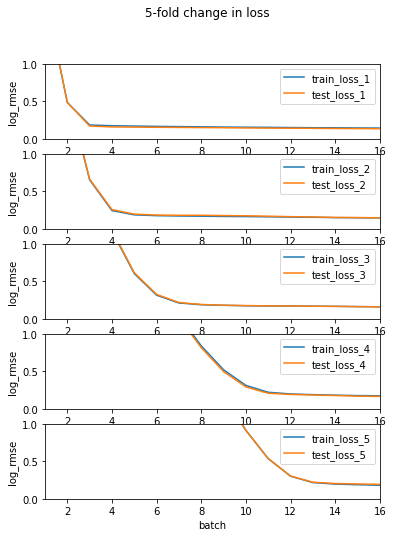

0.1612714409828186 0.16010665595531465


In [13]:
import matplotlib.pyplot as plt
from numpy import append
from IPython import display
%matplotlib inline

k = 5
train_l_sum, test_l_sum = 0, 0

# fig = plt.figure()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
#                            wspace=None, hspace=None)
plt.rcParams['figure.figsize'] = (6, 8)        # 图像显示大小

def plot_subplot(k, no):
    for i in range(k):
        exec('ax{} = plt.subplot({},1,{})'.format(i+1, k, i+1))
        exec('ax{}.set_xlim([1, num_epochs])'.format(i+1))
        exec('ax{}.set_ylim([0, 1])'.format(i+1))
        exec('ax{}.set_xlabel(\'batch\')'.format(i+1))
        exec('ax{}.set_ylabel(\'log_rmse\')'.format(i+1))
        if i == no:
            exec(
                'ax{}.plot(range(epoch+2), y[:,0], label=\'train_loss_{{}}\'.format(i+1))'.format(i+1))
            exec(
                'ax{}.plot(range(epoch+2), y[:,1], label=\'test_loss_{{}}\'.format(i+1))'.format(i+1))
            exec('ax{}.legend()'.format(i+1))
        elif i < no:
            exec(
                'ax{}.plot(range(num_epochs+1), y_list[i][:,0], label=\'train_loss_{{}}\'.format(i+1))'.format(i+1))
            exec(
                'ax{}.plot(range(num_epochs+1), y_list[i][:,1], label=\'test_loss_{{}}\'.format(i+1))'.format(i+1))
            exec('ax{}.legend()'.format(i+1))
        else:
            exec(
                'ax{}.plot(range(epoch+2), zero[:,0], label=\'train_loss_{{}}\'.format(i+1))'.format(i+1))
            exec(
                'ax{}.plot(range(epoch+2), zero[:,1], label=\'test_loss_{{}}\'.format(i+1))'.format(i+1))
            exec('ax{}.legend()'.format(i+1))


y_list = []
for j in range(k):

    plt.ion()

    num_epochs = 16

    train_loss = log_rmse(net, train_features.to(dev), train_labels.to(dev))
    test_loss = log_rmse(net, train_features.to(dev), train_labels.to(dev))

    [tr_f, tr_l, te_f, te_l] = get_k_fold_data(
        k, j, train_features, train_labels)

    batch_size = 256

    train_iter = make_iters(tr_f, tr_l, batch_size)
    test_iter = make_iters(te_f, te_l, te_f.shape[0])

    i = 0
    y = np.array([[train_loss, test_loss]])
    zero = np.array([[0, 0]])
    for epoch in range(num_epochs):

        for batch_datas, batch_labels in train_iter:
            i += batch_size
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(batch_datas.to(dev))
            loss = criterion(outputs, batch_labels.to(dev))
            loss.backward()
            optimizer.step()

            # print statistics
            # running_loss += loss.item()
            # if i % 30000 == 1:    # print every 2000 mini-batches
            #     print('[%d, %5d] loss: %.3f' %
            #           (epoch + 1, i + 1, running_loss / (2000/batch_size)))
            #     running_loss = 0.0
            # running_loss = loss.item()

        train_loss = log_rmse(net, tr_f.to(dev), tr_l.to(dev))
        test_loss = log_rmse(net, te_f.to(dev), te_l.to(dev))
        y = np.insert(y, len(y), np.array(
            [train_loss, test_loss]), axis=0)  # 添加i的平方到y轴的数据中
        zero = np.insert(zero, len(zero), np.array([0, 0]), axis=0)

        # print('test_loss={}'.format(test_loss))
        # display.clear_output(wait=True)

        display.clear_output(wait=True)
        plt.clf()
        plt.suptitle("{}-fold change in loss".format(k))
        plot_subplot(k, j)

        plt.pause(0.1)

    y_list.append(y)
    plt.ioff()
    # plt.show()

    # print(log_rmse(net, test_features.to(dev), test_labels.to(dev)))
    train_l_sum += train_loss
    test_l_sum += test_loss

    net.apply(weight_init)  # 加载权重

# plt.ioff()
plt.show()
print(train_l_sum / k, test_l_sum / k)


In [14]:
# print("pred:", net(test_features.to(dev))[-1])
# print("true:", test_labels[-1])

In [15]:
# test_features = torch.tensor(features[n_train:].values, dtype=torch.float)

# preds = net(test_features.to(dev)).cpu().detach().numpy()
# # 将其重新格式化以导出到Kaggle
# test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
# submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
# print(submission)
# submission.to_csv('data/submission.csv', index=False)

        Id  SalePrice
0     1461   0.015119
1     1462   0.021215
2     1463   0.010689
3     1464   0.015159
4     1465   0.013041
...    ...        ...
1454  2915   0.018842
1455  2916   0.022514
1456  2917   0.010346
1457  2918   0.006961
1458  2919   0.006611

[1459 rows x 2 columns]
